In [ ]:
### First we have downloaded a net CDF from the Copernicus Data Store: https://cds.climate.copernicus.eu

In [ ]:
#file = '/Users/gbenz/Downloads/tx10pETCCDI_mon_HadGEM3-GC31-LL_historical_r1i1p1f3_b1981-2010_v20190624_185001-201412_v2-0.nc'

In [1]:
import pandas as pd
import xarray as xr
from rasterstats import zonal_stats
import numpy as np

from utils.unzip import unzip_etccdi_package
from utils.correct_longitude import transform_longitudinal_values
from utils.give_metadata import give_metadata
from utils.temporal_index import find_etccdi_timeindex
from utils.define_request import generate_and_validate_request

# Methods ---------------------------------------------------------------------------
from utils.etccdi_to_pg__pointquery import generate_etccdi_temporal_tables__centroid
from utils.etccdi_to_pg import generate_etccdi_temporal_tables


## Access with Copernicus Data Store API:

### Link for instructions on how to set up the API 

#### This is a necessary precondition to run the toolbox built here

The proceeding code provides a correct output but requires a unique user API key. This cannot be simplified much further.

The desirable output is to exclusively change:
- 'variable' 
- product_type
- period
#### ------------------
- start_year = '1995'
- start_month = '01'
- end_year = '2000'
- end_month = '12'

Then if you select 'cold days' a decision tree will be printed with the optional parameters that could be selected for product type and period
Other parameters will be kept standard. 

In [ ]:
# reference_df_y = pd.read_csv('/Users/gbenz/Documents/Climate Data/climate_extremes/data/processed/pg__y.csv', index_col=None)
# reference_df_y = reference_df_y.drop(columns=['Unnamed: 0'], errors='ignore')

# # Convert 'year' to string
# reference_df_y['year'] = reference_df_y['year'].astype(str)

# print(reference_df_y.dtypes)

# reference_df_m = pd.read_csv('/Users/gbenz/Documents/Climate Data/climate_extremes/data/processed/pg__m.csv', index_col=None)
# reference_df_m = reference_df_m.drop(columns=['Unnamed: 0'], errors='ignore')

# # Convert 'year' to string
# reference_df_m['year'] = reference_df_m['year'].astype(str)

# # Convert 'month' to an integer first (removes decimals) and then to string
# reference_df_m['month'] = reference_df_m['month'].astype(int).astype(str)

# print(reference_df_m.dtypes)

In [ ]:
# print(reference_df_m)
# print(reference_df_m.dtypes)
# reference_df_m.to_csv('/Users/gbenz/Documents/Climate Data/climate_extremes/data/processed/pg___m.csv')

# print(reference_df_y)
# print(reference_df_y.dtypes)

# reference_df_y.to_csv('/Users/gbenz/Documents/Climate Data/climate_extremes/data/processed/pg___y.csv')

In [ ]:
# ref = pd.read_csv('/Users/gbenz/Documents/Climate Data/climate_extremes/data/processed/pg___y.csv')

# print(ref.dtypes)

In [2]:
# Now, calling the function will generate and validate the request
request = generate_and_validate_request(
    variable="consecutive_dry_days",
    product_type="base_independent",
    experiment="historical",
    temporal_aggregation="yearly"
)

display(request)

#-------------------------------------------------------------------
# Load a clean PG dataframe at a consistent temporal resolution
# to the request built
#-------------------------------------------------------------------

temporal_aggregation_value = request['temporal_aggregation'][0]

if temporal_aggregation_value == 'yearly':
    reference_df = pd.read_csv('/Users/gbenz/Documents/Climate Data/climate_extremes/data/processed/pg__y.csv')
    reference_df= reference_df.drop(columns=['Unnamed: 0'], errors='ignore')
#-------------------------------------------------------------------
    # Convert 'year' to string
    reference_df['year'] = reference_df['year'].astype(str)
#-------------------------------------------------------------------
    print(reference_df.dtypes)

else:
    reference_df = pd.read_csv('/Users/gbenz/Documents/Climate Data/climate_extremes/data/processed/pg__m.csv')
    reference_df = reference_df.drop(columns=['Unnamed: 0'], errors='ignore')
#-------------------------------------------------------------------
    # Convert 'year' to string
    reference_df['year'] = reference_df['year'].astype(str)

    # Convert 'month' to an integer first (removes decimals) and then to string
    reference_df['month'] = reference_df['month'].astype(int).astype(str)
#-------------------------------------------------------------------
    print(reference_df.dtypes)


Request is valid.


{'variable': ['consecutive_dry_days'],
 'product_type': ['base_independent'],
 'model': ['hadgem3_gc31_ll'],
 'ensemble_member': ['r1i1p1f3'],
 'experiment': ['historical'],
 'temporal_aggregation': ['yearly'],
 'period': ['1850_2014'],
 'version': ['2_0'],
 'data_format': 'netcdf'}

priogrid_gid     int64
year            object
dtype: object


In [3]:
import cdsapi

dataset = "sis-extreme-indices-cmip6"

# Extract the desired elements from the request dictionary
variable = request["variable"][0]
temporal_aggregation = request["temporal_aggregation"][0]
period = request["period"][0]

# Concatenate them with an underscore or any other separator you prefer
zip_file_name = f"{variable}_{temporal_aggregation}_{period}.zip"

client = cdsapi.Client()
client.retrieve(dataset, request, target=zip_file_name)


2024-11-13 11:21:57,111 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-13 11:21:57,113 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-13 11:21:57,114 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-13 11:21:57,115 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

432716f0a4b4f4f0049e5f147da23357.zip:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

'consecutive_dry_days_yearly_1850_2014.zip'

In [4]:
netcdf_file, etccdi_index = unzip_etccdi_package(zip_file_name)

cddETCCDI
Extracted file names: cddETCCDI_yr_HadGEM3-GC31-LL_historical_r1i1p1f3_no-base_v20190624_1850-2014_v2-0.nc


### Report Metadata from the selected ETTCDI netCDF file:

Move the pg shapefile to the github repo so this can be accessed without references to local paths

Accomplishes:
- checks to ensure the correct netcdf file is being processed
- provides spatial and temporal metadata

From preprocessing, we know that the ETCCDI climate data is not packaged in a desirable format, that is, the original longitudinal range is: 0.9375 to 359.0625
- Adjust the Longitude range 
- save an 'adjusted netcdf' file.


28-10 -- What would perhaps be most desirable is to first transform, then, report metadata with two seperate functions.

In [5]:
etccdi = transform_longitudinal_values(etccdi_index, netcdf_file)

The variable 'cddETCCDI' was found in the file path and the world continues to spin.
Original Latitude range: -89.375 to 89.375
Original Longitude range: 0.9375 to 359.0625
Adjusted Longitude range: -179.0625 to 179.0625
Adjusted dataset saved to: /Users/gbenz/Downloads/adjusted_cddETCCDI_yr_HadGEM3-GC31-LL_historical_r1i1p1f3_no-base_v20190624_1850-2014_v2-0.nc.nc


In [6]:
give_metadata(etccdi)

Latitude range: -89.375 to 89.375
Longitude range: -179.0625 to 179.0625
Latitude resolution: 1.25
Longitude resolution: 1.875
Global Metadata:
CDI: Climate Data Interface version 1.8.0 (http://mpimet.mpg.de/cdi)
history: Tue Nov 24 08:58:40 2020: cdo mergetime tasmax_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_18500101-19491230.nc tasmax_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500101-20141230.nc ./merged/tasmax_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_18500101-20141230.nc
2019-06-19T11:16:23Z ; CMOR rewrote data to be consistent with CMIP6, CF-1.7 CMIP-6.2 and CF standards.;
2019-06-19T11:07:16Z MIP Convert v1.1.0, Python v2.7.12, Iris v1.13.0, Numpy v1.13.3, netcdftime v1.4.1.
source: HadGEM3-GC31-LL (2016): 
aerosol: UKCA-GLOMAP-mode
atmos: MetUM-HadGEM3-GA7.1 (N96; 192 x 144 longitude/latitude; 85 levels; top level 85 km)
atmosChem: none
land: JULES-HadGEM3-GL7.1
landIce: none
ocean: NEMO-HadGEM3-GO6.0 (eORCA1 tripolar primarily 1 deg with meridional refinement down to 1/3 de

In [7]:
#-----------------------------------------------------------
# Define Start Year & Month
#-----------------------------------------------------------
start_year = '1990'
start_month = '01'
#-----------------------------------------------------------
# Define End Year & Month
end_year = '1993'
end_month = '12'
#-----------------------------------------------------------
#-----------------------------------------------------------
# Establish Start and End index values:
start_index_val, loc_start_month, loc_start_year =  find_etccdi_timeindex(start_year, start_month, etccdi)
print()
end_index_val, loc_end_month, loc_end_year = find_etccdi_timeindex(end_year, end_month, etccdi)
print()
#-----------------------------------------------------------
print(f'The start index is: {start_index_val}, referencing Month: {loc_start_month} and Year: {loc_start_year}')
print()
print(f'The end index is: {end_index_val}, referencing Month: {loc_end_month} and Year: {loc_end_year}')
print()
#-----------------------------------------------------------
index_list = list(range(start_index_val, end_index_val + 1))
#-----------------------------------------------------------

#-----------------------------------------------------------
# Filter the PG reference file to the temporal parameters now established:
#-----------------------------------------------------------

# For annual:
# the etccdi dataframe will contain a month field but this is irrelevant because the temporal resolution is 1-year

# For monthly:
# why don't you filter for a monthly attribute?: Because all months will be included when subsetting by year.
reference_filtered_time = reference_df.loc[(reference_df['year'] >= loc_start_year) & (reference_df['year'] <= loc_end_year)]
#-----------------------------------------------------------
print(reference_filtered_time)

No data found for 01 of the year 1990 but located data for the first available month.
Validation: Found data for Year: 1990, Month: 06 at index 140.

No data found for 12 of the year 1993 but located data for the first available month.
Validation: Found data for Year: 1993, Month: 06 at index 143.

The start index is: 140, referencing Month: 06 and Year: 1990

The end index is: 143, referencing Month: 06 and Year: 1993

        priogrid_gid  year
131100         62356  1990
131101         79599  1990
131102         79600  1990
131103         79601  1990
131104         80317  1990
...              ...   ...
183535        190496  1993
183536        190507  1993
183537        190508  1993
183538        190510  1993
183539        190511  1993

[52440 rows x 2 columns]


### Testing on the first n elements:

In [ ]:
sub_index = index_list[:2]

time_length_subset = len(sub_index)
time_length = len(index_list)

print(time_length_subset)
print(time_length)

print(sub_index)

### Puts it all together

Parameters:
1. references the sub_index which supplies the list (or sublist) of indexes to iterate over. Index specifically references time. This can be confusing because the ETCCDI variables are themselves climate indices.
2. Creates a single geotiff from the current time selection. We do this because the NetCDF itself is not a format that can be incorporated into rigorous analysis so as we iterate through the time series we convert the working item to a geotiff which is a format that can be operated on.


#### Parameters:

1. NetCDF file
2. (TEMPORAL) sub_index or full index (specify index to loop over)
3. etccdi index ex(tx10pETCCDI)


ADF -- Decision to just save to ONE WORKING raster that will continously be rewritten 
rationale: The purpose of having unique tifs is to visualize holes in the data. However, this is not worth the space. If holes appear in the tabular dataset, a new geotiff corresponding to that month / year can quickly be produced!

ADF -- Rationalize why this is best:
    # Resample the raster data to the new resolution
    resampled_raster = raster_data.rio.reproject(
        raster_data.rio.crs,
        shape=(
            int(raster_data.shape[1] * 10),  # Increase number of rows by a factor of 10
            int(raster_data.shape[2] * 10)   # Increase number of columns by a factor of 10
        ),
        resampling=Resampling.bilinear  # Use the correct resampling method
    )


### Params:

- time_index_list,
- netcdf, climate_index, 
- shapefile_path


## Summarize Option 1:

This code generates temporal statistics for a specified climate index by iterating over selected time indices in a NetCDF file. For each time index, it reads climate data, handles data types, renames spatial dimensions, and ensures the correct CRS is set. The data is saved as both an original raster and a modified version with null values set to -9999. Using bilinear interpolation, the code then upscales the raster data by a specified factor and saves this upsampled raster. The upsampled raster is used to compute zonal statistics over regions defined in a shapefile, and these statistics are stored in a GeoDataFrame. Each resulting GeoDataFrame, containing the mean climate index values per region, is appended to a list. After processing all time indices, the code concatenates the list into a final DataFrame, which is saved as a CSV file in the specified output folder. Optional plots display the data at each step.

# Summarize Option 2:

This code processes climate index data from a NetCDF file and extracts raster values for specific geographic regions over multiple time indices. It starts by loading a shapefile of geographic zones and calculates centroids for each polygonal region. For each time index, it reads climate data corresponding to a specific parameter, converting it to days if necessary, and setting spatial dimensions and CRS if undefined. The raster data is temporarily saved as a GeoTIFF file, and the point_query function is used to sample raster values at the centroids of each zone. These sampled values are added to the shapefile's GeoDataFrame and stored in a list for each time index. After the loop, all GeoDataFrames are concatenated into a single DataFrame (final_gdf), which is saved as a CSV file. The script also includes optional plotting of each time slice and closes the NetCDF file when finished.

## Expanding on an recurring issue:

Resampling and Masking
When you resample a raster, you're creating a new grid with finer or coarser resolution based on the original raster. The new grid’s cells are re-sized compared to the original cells. For example, if you resample a raster by a factor of 3, the original cells are subdivided into 9 smaller cells (in a 3x3 grid).

A mask is a boolean grid (same resolution as the raster) used to filter out or mark specific areas of interest. This mask typically identifies areas of the raster with valid data (True) or invalid data (False, or NaN, in case of missing data). When resampling, the mask should align with the resampled raster so that only valid cells are used for resampling operations, and invalid cells remain excluded.

However, issues arise if the mask is derived from the original grid, and you resample that original grid. Here's why:

The Root Cause of Misalignment
Misalignment of Grids:
After resampling, the new raster's resolution is finer, which means you now have smaller cells within the same bounding box. But since you're using the original raster's mask (which was designed for the coarser grid), this mask will no longer fit exactly with the new raster. The finer resolution raster has different boundaries, so the mask may not align correctly to the finer grid cells.
In other words:

The original mask may cover a large region (since it was based on the coarser grid cells).
The new resampled raster will now have many more cells that represent the same area, but the mask won't scale automatically to match the new resolution.
Valid Mask Misalignment: The original raster's valid mask might indicate areas of valid data and invalid data at a coarse resolution, but once you resample, the mask needs to be resampled in the same way as the data. This allows the valid/invalid distinction to remain accurate for each finer cell.
However, if you don't reapply the valid mask to the resampled raster, or if the resampling of the mask is not done properly, you'll end up with an incorrect alignment between the valid and invalid areas. This can result in several issues:

The resampling process might use invalid data (or leave gaps in data) in areas where the mask says the data should be valid.
The finer grid might end up with spatial misalignment where valid areas on the original grid are incorrectly marked as invalid (or vice versa) on the finer grid.
More Specifically:
Resampling Method and Masking: When you perform resampling, the method you choose (e.g., bilinear, cubic) may try to interpolate the values of neighboring cells. If the original cells have null values or missing data, the resampling method may propagate these null values into the newly resampled cells, unless you specifically exclude them from the interpolation process. This could lead to introducing new null areas in the resampled raster.
For example, if you have a coarser raster with some missing data, and you choose bilinear interpolation for resampling, the new finer cells may get assigned interpolated values from neighboring cells that had data. But if those neighboring cells also have missing data, this could result in interpolated null values, leading to a larger area of missing data than you originally had.
When the Mask Doesn't Align: Consider this scenario:
The original raster has cells with valid data, but those valid cells may not exactly match the boundaries of the finer resampled raster.
If you simply apply the original valid mask (from the coarser raster) to the finer resampled raster without rescaling or adjusting the mask, you could misalign areas of valid data and invalid data.
In practice:

If the original mask had valid data in one coarse cell, after resampling, that coarse cell becomes nine smaller cells. Some of those smaller cells might fall into areas where the mask from the coarser raster still marks them as invalid (because the original mask was larger and not rescaled).
The new cells in the resampled raster should be individually checked for validity. A resampled mask ensures that only the valid data is used for interpolation and no new invalid data is introduced.
A Visual Example: Let's say your original raster has a grid with one valid cell, and the surrounding cells are null (missing). After resampling:
Without a rescaled mask, some of the new finer grid cells could be treated as valid, even though the original data was null.
With the correct rescaled mask, the valid area is preserved in the resampled grid, and only valid data is used to fill the finer cells.
Conclusion:
The problem occurs because you need to resample both the data and the mask at the same time. If the mask isn't rescaled to match the new finer grid, areas that should be marked as invalid might get wrongly marked as valid, leading to interpolation errors. These errors may introduce new null values where they didn’t exist in the original raster, because the resampling method tries to fill in gaps based on a misaligned mask.
To avoid this:

Ensure that both the data and the mask are resampled with the same grid size.
Resample the mask correctly to the finer resolution, maintaining the valid and invalid regions, so that the resampling of the data follows the mask boundaries exactly.
If interpolation is involved, make sure to avoid interpolating over null values to prevent the introduction of invalid data.
In Summary:
Misalignment occurs when the resampling process changes the raster's resolution but fails to correctly adjust the associated valid mask. When the mask isn't resampled, you risk introducing new null areas or misclassifying valid/invalid cells. This can create errors in downstream processes, such as zonal statistics or further analysis, where invalid data is improperly considered valid or vice versa.

Processing time index: 140
Year: 1990 Month: 06
CRS is not set. Setting CRS to EPSG:4326


/Users/gbenz/Documents/Climate Data/climate_extremes/utils/etccdi_to_pg__pointquery.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid
/Users/gbenz/miniforge3/envs/viewser/lib/python3.11/site-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


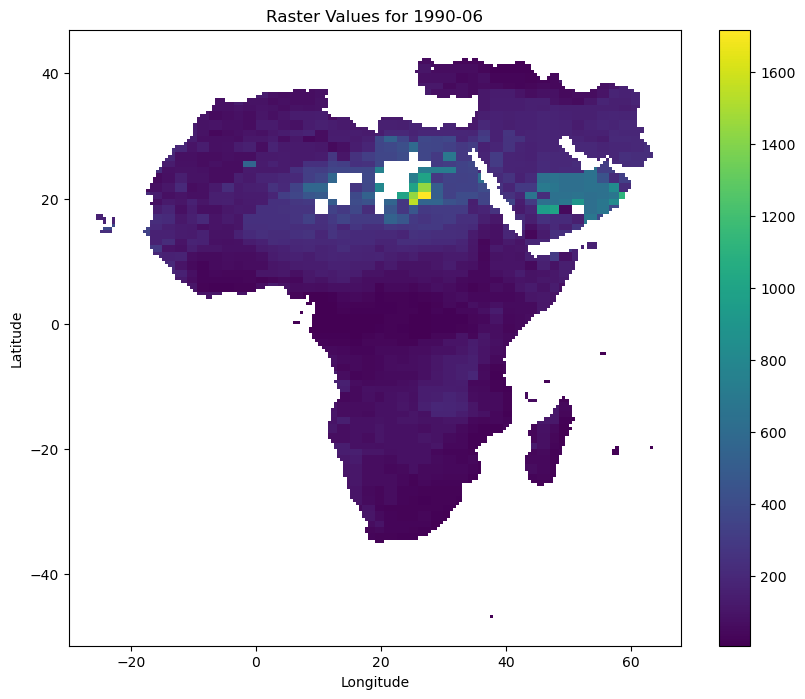

Processing time index: 141
Year: 1991 Month: 06
CRS is not set. Setting CRS to EPSG:4326


/Users/gbenz/Documents/Climate Data/climate_extremes/utils/etccdi_to_pg__pointquery.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


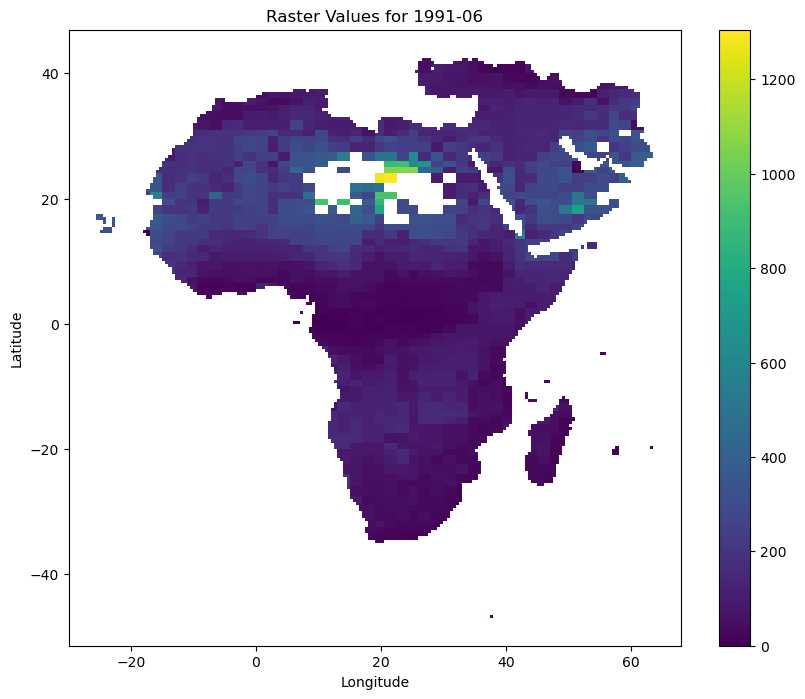

Processing time index: 142
Year: 1992 Month: 06
CRS is not set. Setting CRS to EPSG:4326


/Users/gbenz/Documents/Climate Data/climate_extremes/utils/etccdi_to_pg__pointquery.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


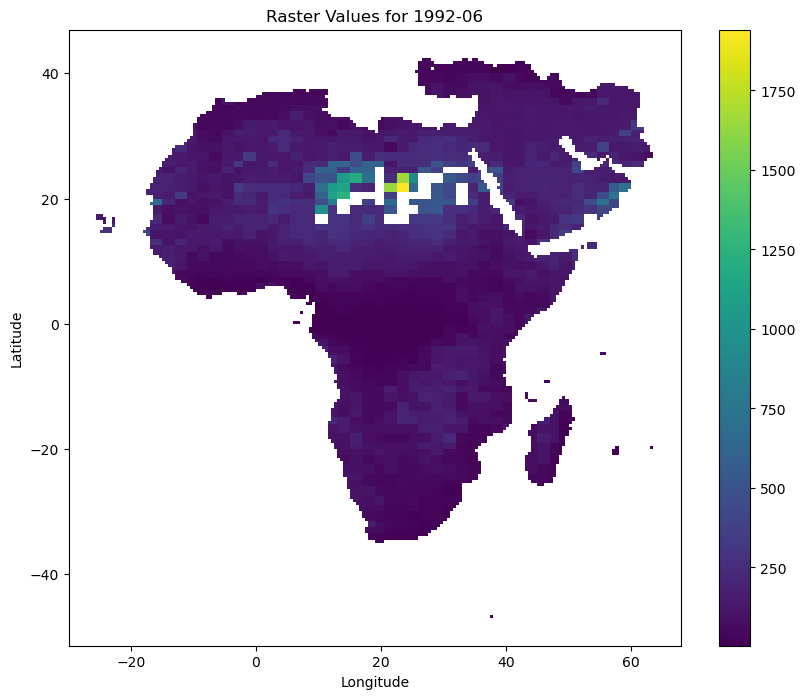

Processing time index: 143
Year: 1993 Month: 06
CRS is not set. Setting CRS to EPSG:4326


/Users/gbenz/Documents/Climate Data/climate_extremes/utils/etccdi_to_pg__pointquery.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid


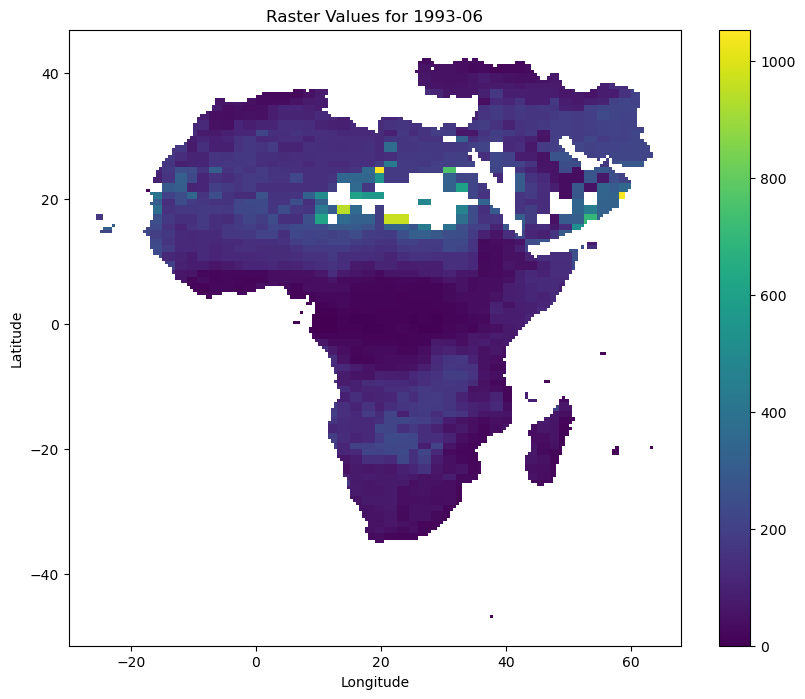

Final DataFrame saved to: /Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/cddETCCDI_140_143__centroid_process.csv


In [8]:
generate_etccdi_temporal_tables__centroid(index_list, etccdi, etccdi_index, '/Users/gbenz/Downloads/pg_extent/pgm_viewser_extent.shp', '/Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/')

In [9]:
validate_etccdi = pd.read_csv('/Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/cddETCCDI_140_143__centroid_process.csv')
print(validate_etccdi)


          gid                                           geometry  xcoord  \
0      190494  POLYGON ((26.50000000019992 41.999999999800195...   26.75   
1      190495  POLYGON ((27.000000000099988 41.99999999980019...   27.25   
2      190496  POLYGON ((27.500000000000057 41.99999999980019...   27.75   
3      190507  POLYGON ((32.999999999800195 41.99999999980019...   33.25   
4      190508  POLYGON ((33.499999999700265 41.99999999980019...   33.75   
...       ...                                                ...     ...   
52435   79600  POLYGON ((19.499999999800195 -35.0000000000998...   19.75   
52436   79601  POLYGON ((19.999999999700265 -35.0000000000998...   20.25   
52437  116373  POLYGON ((45.999999999900126 -9.49999999980008...   46.25   
52438  116374  POLYGON ((46.499999999800195 -9.49999999980008...   46.75   
52439   62356  POLYGON ((37.499999999800195 -47.0000000003996...   37.75   

       ycoord  Point_query_result  year  month  
0       42.25                63.0  199

In [ ]:
generate_etccdi_temporal_tables(index_list, etccdi, etccdi_index, '/Users/gbenz/Downloads/pg_extent/pgm_viewser_extent.shp', '/Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/')

In [ ]:
validate_etccdi = pd.read_csv('/Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/cddETCCDI_140_143__centroid_process.csv')
print(validate_etccdi)

### Review:

#### Validate completeness of the output index at PG resolution:

Temporally: check that all total number of time periods match
- Spatially: Full extent of PG (for each temporal unit!)

How to do this:

1. Load the 'compiled' etccdi index .csv
2. check for null values

Total length should be: X

check length of temporal units should be: X (dependent on input parameters)
check length of spatial units should be: X

3. Plot the data

### What we need:

A complete 'clean' dataframe to reference from VIEWSER! 11.11


# Code Changes:


In the Point Query process: Point_query_result field name needs to be adjusted to reflect the actual indice being evaluated! 11.12.2024

### Templated for an indice reporting a YEAR temporal resolution

this should become a paramter:
- `right_on=['gid', 'year'],  # Columns in validate_etccdi`
- `nan_summary_df = null_cddETCCDI_rows.groupby(['year'])['Point_query_result'].apply(lambda x: x.isna().sum()).reset_index()`


In [14]:
# import geopandas as gpd

# # Specify the path to your shapefile or other spatial data file
# file_path = '/Users/gbenz/Downloads/pg_extent/pgm_viewser_extent.shp'

# # Load the data into a GeoDataFrame
# gdf = gpd.read_file(file_path)

# spatial_extent = len(pd.unique(gdf['gid']))

#------------------------------------------------------------------------------------
#load the developed Climate index 
#------------------------------------------------------------------------------------
validate_etccdi = pd.read_csv('/Users/gbenz/Documents/Climate Data/climate_extremes/data/generated/cddETCCDI_140_143__centroid_process.csv')
validate_etccdi['date'] = validate_etccdi['year'].astype(str) + '-' + validate_etccdi['month'].astype(str).str.zfill(2)
validate_etccdi['year'] = validate_etccdi['year'].astype(str)

etccdi_time_length = len(pd.unique(validate_etccdi['date']))
etccdi_spatial_length = len(pd.unique(validate_etccdi['gid']))
#------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------
# Perform a left join on the 'priogrid_gid' and 'gid' columns, and 'year'
#------------------------------------------------------------------------------------
merged_df = reference_filtered_time.merge(
    validate_etccdi,
    how='left',  # Keeps all rows from reference_filtered_time
    left_on=['priogrid_gid', 'year'],  # Columns in reference_filtered_time
    right_on=['gid', 'year'],  # Columns in validate_etccdi
    suffixes=('_reference', '_validate')  # Optional: Adds suffixes to distinguish overlapping columns
)
#------------------------------------------------------------------------------------
# Check the result
print(merged_df.head())
#------------------------------------------------------------------------------------

#------------------------------------------------------------------------------------
# Filter the merged DataFrame to find rows where the 'cddETCCDI' field is NaN
null_cddETCCDI_rows = merged_df[merged_df['Point_query_result'].isna()]
print('printing null_cddETCCDI_rows results:')

print(null_cddETCCDI_rows)
#------------------------------------------------------------------------------------



# Group by 'year' and count NaN values in the 'Point_query_result' column
nan_summary_df = null_cddETCCDI_rows.groupby(['year'])['Point_query_result'].apply(lambda x: x.isna().sum()).reset_index()

# Rename columns for clarity
nan_summary_df.columns = ['year', 'NaN_count']

# Display the result
print(nan_summary_df)

#------------------------------------------------------------------------------------
# Get a summary of the rows with NaN in the 'cddETCCDI' field
#------------------------------------------------------------------------------------
total_nulls_validate = merged_df.isna().sum().sum()

print(f"Total number of null values in 'validate_etccdi' DataFrame: {total_nulls_validate}")
#------------------------------------------------------------------------------------


   priogrid_gid  year    gid  \
0         62356  1990  62356   
1         79599  1990  79599   
2         79600  1990  79600   
3         79601  1990  79601   
4         80317  1990  80317   

                                            geometry  xcoord  ycoord  \
0  POLYGON ((37.499999999800195 -47.0000000003996...   37.75  -46.75   
1  POLYGON ((18.999999999900126 -35.0000000000998...   19.25  -34.75   
2  POLYGON ((19.499999999800195 -35.0000000000998...   19.75  -34.75   
3  POLYGON ((19.999999999700265 -35.0000000000998...   20.25  -34.75   
4  POLYGON ((18.000000000099988 -34.5000000001998...   18.25  -34.25   

   Point_query_result  month     date  
0                 7.0      6  1990-06  
1                23.0      6  1990-06  
2                23.0      6  1990-06  
3                23.0      6  1990-06  
4                28.0      6  1990-06  
printing null_cddETCCDI_rows results:
       priogrid_gid  year     gid  \
7614         155180  1990  155180   
7615         155181  1